In [1]:
import os
os.chdir('..')

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

# SNLI

In [243]:
df = pd.read_csv('outputs/train/snli/flip0.1_bert/121_2022-12-31_20-19-06/tracing/eval_result.csv')
df = df.rename(
    columns={
        "SA_core.tracer.GradientBasedTracer": "SA_GD",
        "SA_core.tracer.IF": "SA_IF",
        "SA_core.tracer.TracIn": "SA_TracIn",
        "SC_core.tracer.GradientBasedTracer": "SC_GD",
        "SC_core.tracer.IF": "SC_IF",
        "SC_core.tracer.TracIn": "SC_TracIn",
    }
)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/train/snli/flip0.1_bert/121_2022-12-31_20-19-06/tracing/eval_result.csv'

In [244]:
df

NameError: name 'df' is not defined

In [245]:
melt_df = df.drop(columns=['top_size', 'num_error']).melt('top', var_name='method', value_name='prec')
melt_df['aggregation'] = melt_df.apply(lambda x: x['method'].split('_')[0], axis=1)
melt_df['influence_score'] = melt_df.apply(lambda x: x['method'].split('_')[1], axis=1)

NameError: name 'df' is not defined

In [ ]:
melt_df

,top,method,prec,aggregation,influence_score
0,0.05,SA_GD,55.981505,SA,GD
1,0.10,SA_GD,43.432358,SA,GD
2,0.15,SA_GD,32.190186,SA,GD
3,0.20,SA_GD,24.918087,SA,GD
4,0.05,SC_GD,67.088974,SC,GD
5,0.10,SC_GD,61.952090,SC,GD
6,0.15,SC_GD,55.399013,SC,GD
7,0.20,SC_GD,45.388269,SC,GD
8,0.05,SA_IF,52.970731,SA,IF
9,0.10,SA_IF,30.828601,SA,IF


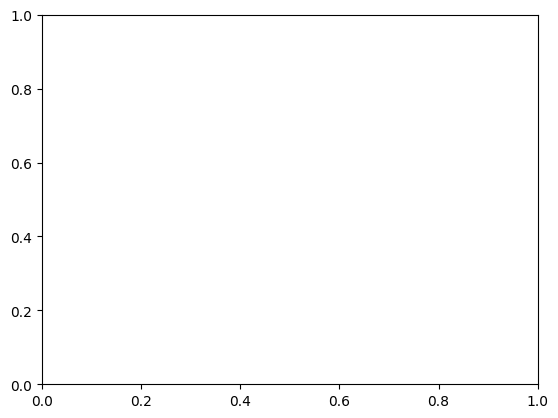

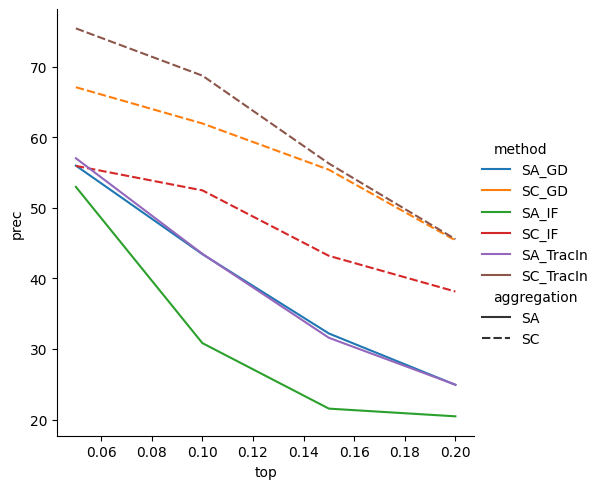

In [ ]:
fig, ax = plt.subplots()
ax = sns.relplot(x='top', y='prec', hue='method', style='aggregation', markers=False, data=melt_df, kind='line')

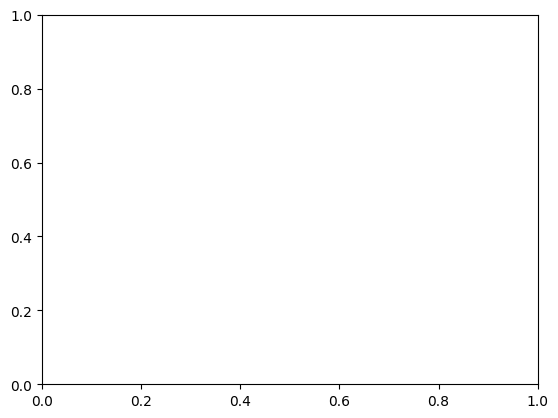

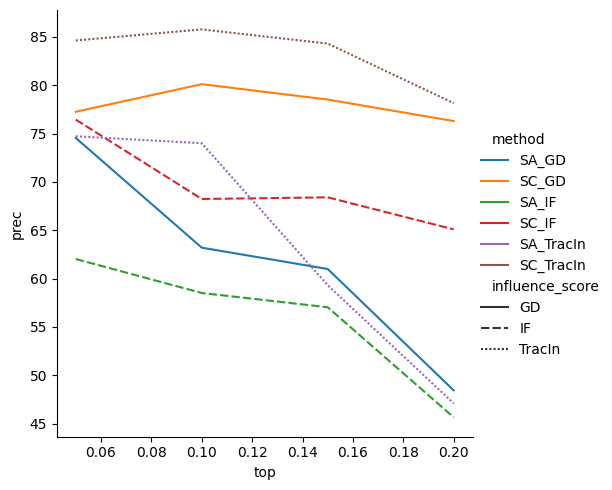

In [ ]:
fig, ax = plt.subplots()
ax = sns.relplot(x='top', y='prec', hue='method', style='influence_score', markers=False, data=melt_df, kind='line')

# IMDb - Real Data

In [100]:
output_dirs = '''real_imdb_results/121_2023-01-02_12-11-48
real_imdb_results/122_2023-01-02_12-11-48
real_imdb_results/123_2023-01-02_12-11-48
real_imdb_results/124_2023-01-02_12-12-57
real_imdb_results/125_2023-01-02_12-12-57'''
# output_dirs = '''real_imdb_results/124_2023-01-02_12-12-57'''

def get_best_ckpt(checkpoint_dir: Path):
    # metrics = [(float(re.search('val_acc=([+-]?([0-9]*[.])?[0-9]+)', str(p)).group(1)),p) for p in checkpoint_dir.glob("epoch*.ckpt.csv")]
    # metrics.sort(reverse=True)
    metrics = [(float(re.search('epoch=([+-]?([0-9]*[.])?[0-9]+)', str(p)).group(1)),p) for p in checkpoint_dir.glob("epoch*.ckpt.csv")]
    metrics.sort(reverse=False)

    best_ckpt_path = metrics[0][1]
    return best_ckpt_path

avail_aggregation = ["KNN", "SC", "SA"]
avail_influence = ["GD", "GN", "GC", "IF"]

def extract_info_from_name(df):
    avail_aggregation = ["KNN", "SC", "SA"]
    avail_influence = ["GD", "GN", "GC", "IF"]
    def extract(s):
        method = s["method"].split("_")
        if len(method) == 1:
            return s
        s["aggregation"] = method[0] if method[0] in avail_aggregation else None
        s["influence"] = method[1] if method[1] in avail_influence else None
        s["k"] = int(method[-1]) if s["aggregation"] == "KNN" else None
        return s
    return df.apply(extract, axis=1)

def extract_info_from_name_row(s):
    method = s["method"].split("_")
    if len(method) == 1:
        return s
    s["aggregation"] = method[0] if method[0] in avail_aggregation else None
    s["influence"] = method[1] if method[1] in avail_influence else None
    s["k"] = int(method[-1]) if (s["aggregation"] == "KNN" and method[-1].isdigit())  else None
    return s

In [101]:
best_ckpt_results = []
for run in output_dirs.split('\n'):
    run = Path(run)
    best_ckpt_path = get_best_ckpt(run / "checkpoints")
    best_ckpt_result = pd.read_csv(str(best_ckpt_path))
    best_ckpt_result = best_ckpt_result.drop(columns="Unnamed: 0")
    best_ckpt_result["run"] = run.name
    best_ckpt_results.append(best_ckpt_result)
best_ckpt_results = pd.concat(best_ckpt_results, axis=0, ignore_index=True)
best_ckpt_results["method"] = best_ckpt_results["method"].apply(lambda x: "LengthGD" if x == "Length_GD" else x)
grouped_df = best_ckpt_results.groupby(["method"], as_index=False)

In [102]:
mean_df = grouped_df.mean(numeric_only=True)
mean_df = extract_info_from_name(mean_df)
mean_df = mean_df.set_index("method")
mean_df.head(20)

,aggregation,influence,k,top100,top1000,top1050,top1100,top1150,top1200,top1250,...,top500,top550,top600,top650,top700,top750,top800,top850,top900,top950
method,,,,,,,,,,,,,,,,,,,,,
KNN_100,KNN,None,100.0,69.999999,56.599998,56.857145,56.272727,56.086957,55.416667,55.519998,...,68.000001,66.727275,63.999999,62.000000,59.857142,58.933336,57.249999,56.352943,56.333333,56.315792
KNN_1000,KNN,None,1000.0,73.000002,57.400000,57.428569,57.363635,56.434780,55.750000,55.440003,...,67.600000,66.363639,65.666670,64.769232,62.428570,60.000002,59.875000,58.588237,57.555556,57.263160
KNN_110,KNN,None,110.0,69.999999,56.599998,56.952381,56.272727,56.173915,55.416667,55.519998,...,67.600000,66.181821,63.166666,60.923076,60.000002,58.800000,57.125002,56.470591,56.222224,56.315792
KNN_120,KNN,None,120.0,69.999999,56.699997,56.857145,56.363636,56.173915,55.416667,55.440003,...,67.799997,66.727275,63.499999,61.230767,60.142857,58.666664,57.249999,56.470591,56.222224,56.526315
KNN_130,KNN,None,130.0,72.000003,56.900001,57.047617,56.545454,56.347823,55.666667,55.599999,...,67.400002,66.909093,64.833331,61.692309,59.571427,59.066665,57.999998,56.941175,56.555557,56.842107
KNN_140,KNN,None,140.0,75.000000,56.800002,56.952381,56.454545,56.260872,55.583334,55.440003,...,67.400002,67.090911,64.833331,62.153846,60.000002,59.466666,57.625002,56.588233,56.444442,56.736845
KNN_150,KNN,None,150.0,74.000001,56.900001,57.047617,56.545454,56.260872,55.416667,55.519998,...,67.400002,66.545457,65.166664,62.461537,60.571426,60.266668,57.999998,56.823528,56.666666,56.842107
KNN_160,KNN,None,160.0,68.000001,56.900001,57.047617,56.636363,56.347823,55.583334,55.440003,...,67.400002,66.545457,64.499998,62.000000,60.000002,58.933336,57.875001,56.941175,56.666666,56.842107
KNN_170,KNN,None,170.0,70.999998,56.900001,57.047617,56.636363,56.260872,55.583334,55.440003,...,67.400002,66.727275,64.999998,62.000000,61.000001,59.600002,57.999998,57.058823,56.444442,56.842107


## Comparation

In [103]:
tmp_df = mean_df[mean_df.aggregation.notnull()]
tmp_df = tmp_df.groupby(["aggregation", "influence"], as_index=False, dropna=False).max()
tmp_df["method"] = tmp_df.apply(lambda r: r["aggregation"] + (f"_{r['influence']}" if not pd.isnull(r["influence"]) else ""), axis=1)
tmp_df = tmp_df.set_index("method")
tmp_df = pd.concat((tmp_df, mean_df[mean_df.aggregation.isnull()]))
tmp_df = tmp_df.drop(columns=["aggregation", "influence", "k", "is_cleanlab"])
tmp_df = tmp_df.T
tmp_df.index = tmp_df.index.map(lambda x: int(x[3:]))
tmp_df = tmp_df.reset_index().rename(columns={"index": "top"})

In [104]:
tmp_df.head(3)

name,top,KNN_GC,KNN_GD,KNN_GN,SA_GC,SA_GD,SA_GN,SC_GC,SC_GD,SC_GN
0,100,79.000002,79.000002,73.000002,72.000003,79.000002,73.000002,73.000002,77.999997,73.000002
1,1000,59.299999,57.099998,56.599998,58.300000,54.600000,56.099999,57.900000,58.899999,57.599998
2,1050,58.952379,56.380951,56.666666,57.714283,53.523809,55.523807,56.952381,57.904762,56.857145


In [105]:
CLEANLAB_METHODS = []
tmp_df = tmp_df.melt('top', var_name='method', value_name='prec')
tmp_df = tmp_df.apply(extract_info_from_name_row, axis=1)
tmp_df['is_cleanlab'] = tmp_df["method"].apply(lambda x: x in CLEANLAB_METHODS)

In [106]:
tmp_df.head(3)

,top,method,prec,aggregation,influence
0,100,KNN_GC,79.000002,KNN,GC
1,1000,KNN_GC,59.299999,KNN,GC
2,1050,KNN_GC,58.952379,KNN,GC


### Aggegration

<AxesSubplot: xlabel='top', ylabel='prec'>

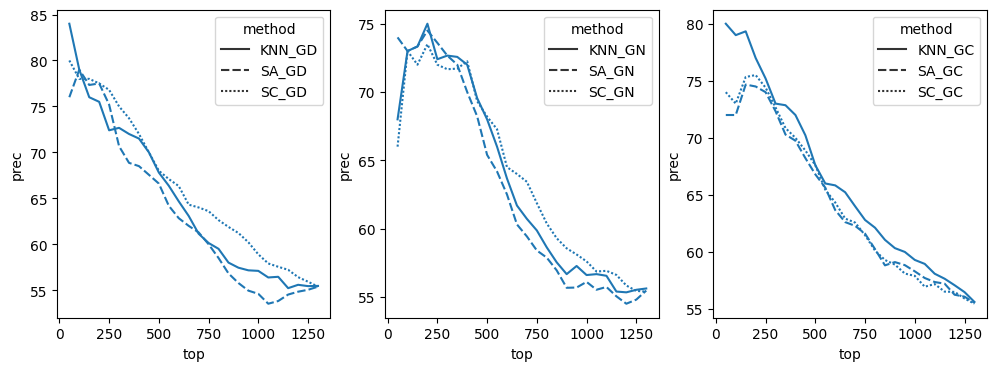

In [107]:
fig, axes = plt.subplots(1,3, figsize=(12, 4))
sns.lineplot(data=tmp_df[tmp_df["influence"] == "GD"], x="top", y="prec", style="method", ax=axes[0])
sns.lineplot(data=tmp_df[tmp_df["influence"] == "GN"], x="top", y="prec", style="method", ax=axes[1])
sns.lineplot(data=tmp_df[tmp_df["influence"] == "GC"], x="top", y="prec", style="method", ax=axes[2])

### Influence

<AxesSubplot: xlabel='top', ylabel='prec'>

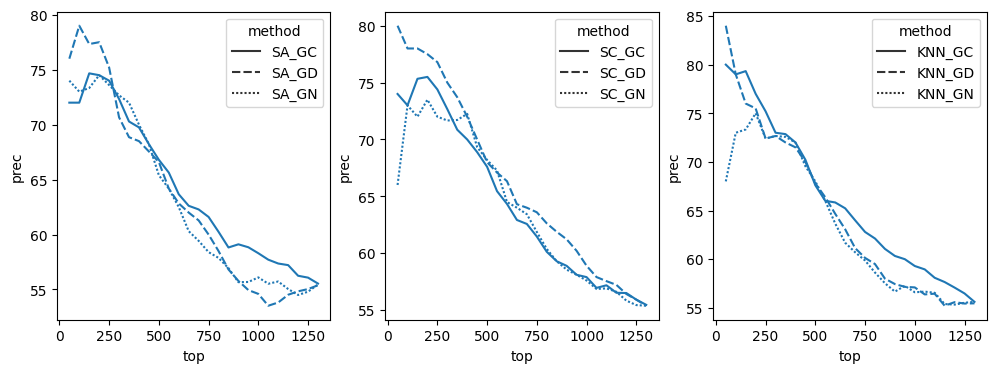

In [108]:
fig, axes = plt.subplots(1,3, figsize=(12, 4))
sns.lineplot(data=tmp_df[tmp_df["aggregation"] == "SA"], x="top", y="prec", style="method", ax=axes[0])
sns.lineplot(data=tmp_df[tmp_df["aggregation"] == "SC"], x="top", y="prec", style="method", ax=axes[1]) 
sns.lineplot(data=tmp_df[tmp_df["aggregation"] == "KNN"], x="top", y="prec", style="method", ax=axes[2])

### KNN

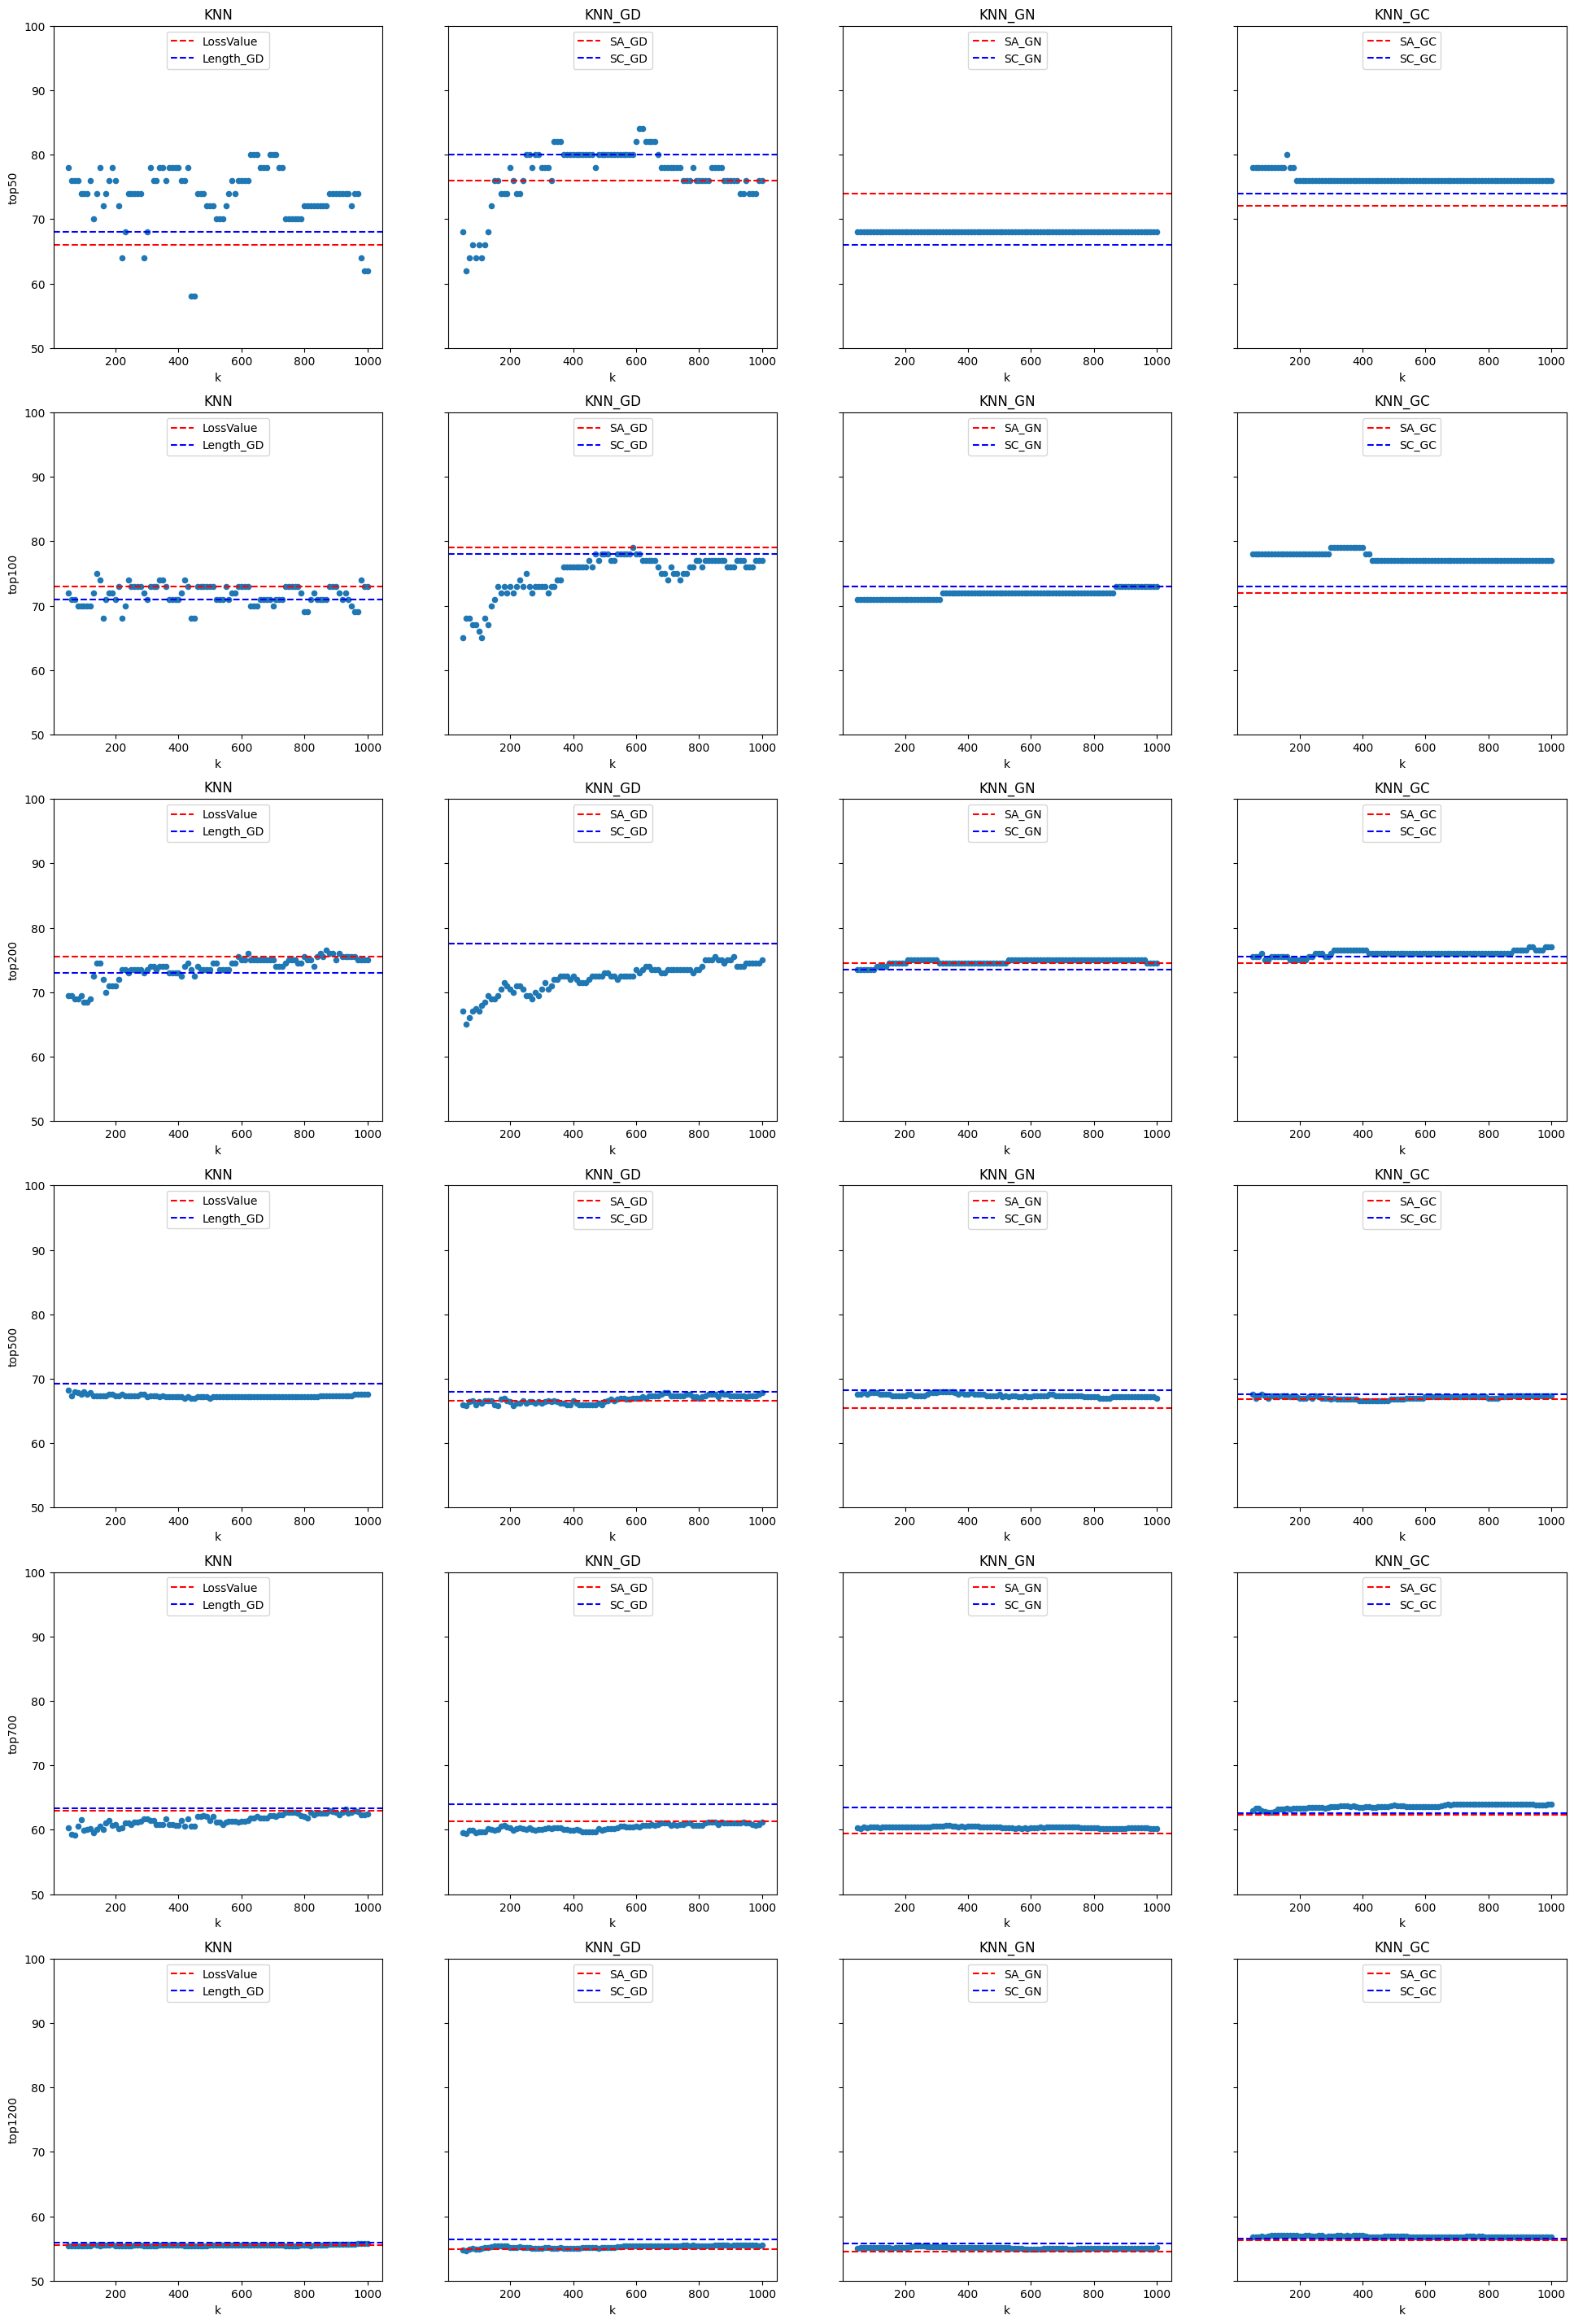

In [109]:
def plot_knn_1(top_plot, axes):
    mean_df[(mean_df.aggregation == "KNN") & (mean_df.influence.isnull())].sort_values(by=top_plot, ascending=False).plot.scatter(x="k", y=top_plot, ax=axes[0])
    axes[0].set_title("KNN")
    axes[0].axhline(y = mean_df.loc["LossValue", top_plot], color = 'r', linestyle = 'dashed', label="LossValue")
    axes[0].axhline(y = mean_df.loc["Length_GD", top_plot], color = 'b', linestyle = 'dashed', label="Length_GD")
    axes[0].legend(loc = 'upper center')
    axes[0].set_ylim((50,100))

    mean_df[(mean_df.aggregation == "KNN") & (mean_df.influence == "GD")].sort_values(by=top_plot, ascending=False).plot.scatter(x="k", y=top_plot, ax=axes[1])
    axes[1].set_title("KNN_GD")
    axes[1].axhline(y = mean_df.loc["SA_GD", top_plot], color = 'r', linestyle = 'dashed', label="SA_GD")
    axes[1].axhline(y = mean_df.loc["SC_GD", top_plot], color = 'b', linestyle = 'dashed', label="SC_GD")
    axes[1].legend(loc = 'upper center')
    axes[1].set_ylim((50,100))

    mean_df[(mean_df.aggregation == "KNN") & (mean_df.influence == "GN")].sort_values(by=top_plot, ascending=False).plot.scatter(x="k", y=top_plot, ax=axes[2])
    axes[2].set_title("KNN_GN")
    axes[2].axhline(y = mean_df.loc["SA_GN", top_plot], color = 'r', linestyle = 'dashed', label="SA_GN")
    axes[2].axhline(y = mean_df.loc["SC_GN", top_plot], color = 'b', linestyle = 'dashed', label="SC_GN")
    axes[2].legend(loc = 'upper center')
    axes[2].set_ylim((55,105))

    mean_df[(mean_df.aggregation == "KNN") & (mean_df.influence == "GC")].sort_values(by=top_plot, ascending=False).plot.scatter(x="k", y=top_plot, ax=axes[3])
    axes[3].set_title("KNN_GC")
    axes[3].axhline(y = mean_df.loc["SA_GC", top_plot], color = 'r', linestyle = 'dashed', label="SA_GC")
    axes[3].axhline(y = mean_df.loc["SC_GC", top_plot], color = 'b', linestyle = 'dashed', label="SC_GC")
    axes[3].legend(loc = 'upper center')
    axes[3].set_ylim((50,100))

fig, axes = plt.subplots(6, 4, figsize=(6*4, 6*6), sharey="row")
plot_knn_1("top50", axes[0])
plot_knn_1("top100", axes[1])
plot_knn_1("top200", axes[2])
plot_knn_1("top500", axes[3])
plot_knn_1("top700", axes[4])
plot_knn_1("top1200", axes[5])

# IMDb - 20% Noise

In [23]:
output_dirs = '''outputs/imdb/flip0.2_bert/121_2023-01-03_19-26-09
outputs/imdb/flip0.2_bert/122_2023-01-03_19-26-09
outputs/imdb/flip0.2_bert/123_2023-01-03_19-26-09
outputs/imdb/flip0.2_bert/124_2023-01-03_19-26-09
outputs/imdb/flip0.2_bert/125_2023-01-03_19-26-09'''

dfs = [pd.read_csv(Path(p) / 'tracing' / 'eval_result.csv') for p in output_dirs.split('\n')]